In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../../src")
from evaluate_gaze import EvaluateGaze

In [3]:
user_id = 8
df = pd.read_csv(f"../data/eval_data/gaze_user{user_id}_eval_9.csv")

df.head()

,flag,xl,yl,zl,xr,yr,zr,xc,yc,zc,...,ray_x,ray_y,ray_z,eye_x,eye_y,eye_z,time,frame,u,v
0,25.0,0.248426,0.092597,0.999742,0.020845,0.037186,0.999811,0.134639,0.064892,0.999776,...,0.132483,0.061997,0.989245,-0.002698,0.000624,-0.025711,37.22222,2319.0,0.175,0.104
1,25.0,0.230530,0.093342,1.000014,0.021595,0.037822,0.999970,0.126061,0.065581,0.999992,...,0.124228,0.062499,0.990283,-0.002699,0.000802,-0.026416,37.23333,2320.0,0.175,0.104
2,25.0,0.226216,0.091450,0.999841,0.021544,0.038308,0.999900,0.123882,0.064880,0.999870,...,0.122162,0.061805,0.990584,-0.002699,0.000839,-0.026549,37.24445,2321.0,0.175,0.104
3,25.0,0.226996,0.092093,0.999879,0.022018,0.038186,0.999913,0.124508,0.065140,0.999896,...,0.122751,0.062048,0.990496,-0.002699,0.000840,-0.026552,37.26667,2322.0,0.175,0.104
4,25.0,0.226703,0.088920,0.999915,0.021500,0.033595,0.999938,0.124102,0.061258,0.999926,...,0.122377,0.058272,0.990772,-0.002698,0.000880,-0.026653,37.27778,2323.0,0.175,0.104


In [4]:
# gaze direction
ray_x = df["ray_x"].values
ray_y = df["ray_y"].values
ray_z = df["ray_z"].values

# gaze direction at z=1
xe = ray_x[:] / ray_z[:] * 1.0
ye = ray_y[:] / ray_z[:] * 1.0

# marker position on a calibration plane at 1m away (HMD coordinates)
p = df["u"].values
q = df["v"].values

# origin (HMD coordinates)
eye_x = df["eye_x"].values
eye_y = df["eye_y"].values
eye_z = df["eye_z"].values

# gaze position on a calibration plane at 1m away (HMD coordinates)
ones = np.ones_like(eye_z)
t = (ones - eye_z) / ray_z
xh = eye_x + t * ray_x
yh = eye_y + t * ray_y

## Evaluate raw gaze direction

In [5]:
param_raw = [0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
param_raw

[0.0, 1.0, 0.0, 0.0, 0.0, 1.0]

In [6]:
rmse_raw = EvaluateGaze.err_rmse_reg(param_raw, xe, ye, eye_x, eye_y, eye_z, p, q)
print(f"RMSE: {rmse_raw}")

angle_err = np.rad2deg(np.arctan(rmse_raw))
print(f"angle_err: {angle_err}")

RMSE: 0.0929298879313335
angle_err: 5.309241933242194


## Evaluate visual axis

In [7]:
pramm_vis = pd.read_csv(f"../param/baseline_param.csv").values[user_id-1]
pramm_vis

array([ 0.011185  ,  1.13912746, -0.12140098,  0.00570246, -0.00412379,
        0.70715595])

In [8]:
# calibrate gaze direction
calib_xe, calib_ye = EvaluateGaze.calibrate_reg(pramm_vis, xe, ye)

# convert gaze position on calibration plane at 1m away (HMD coordinates)
ones = np.ones_like(calib_xe)
t = (ones - eye_z) / 1.0
calib_xh = eye_x + t * calib_xe
calib_yh = eye_y + t * calib_ye

In [9]:
rmse_vis = EvaluateGaze.err_rmse_reg(pramm_vis, xe, ye, eye_x, eye_y, eye_z, p, q)
print(f"RMSE: {rmse_vis}")

angle_err = np.rad2deg(np.arctan(rmse_vis))
print(f"angle_err: {angle_err}")

RMSE: 0.09133125268474729
angle_err: 5.218417818225057


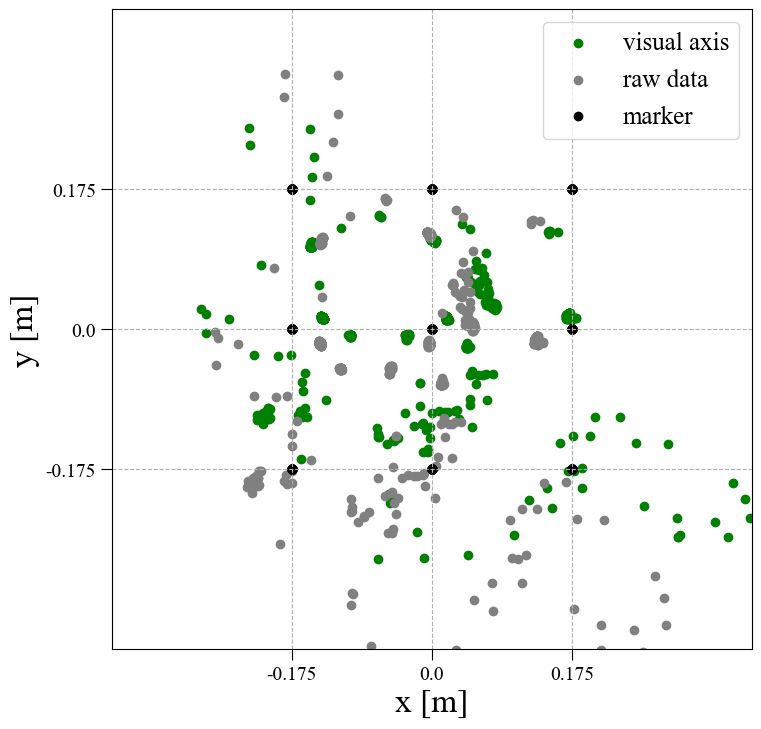

In [10]:
label_xy = [-0.7/4, 0.0, 0.7/4]

# キャリブレーション後
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor("white")

plt.scatter(calib_xh, calib_yh, c="green", label="visual axis")
plt.scatter(xh, yh, c="gray", label="raw data")
plt.scatter(p, q, c="black", label="marker")

plt.xlabel("x [m]",  size=24)
plt.ylabel("y [m]",  size=24)

plt.xlim(-0.4, 0.4)
plt.ylim(-0.4-0.071, 0.4-0.071)
plt.xticks([-0.175, 0.0, 0.175], label_xy, fontsize=14)
plt.yticks([-0.175-0.071, -0.071, 0.175-0.071], label_xy, fontsize=14)

plt.grid(which="major", axis="both", linestyle='--')
plt.tick_params(length=8)
plt.legend(fontsize=18, loc="upper right")
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9)
plt.show()

## Evaluate optical axis

In [11]:
param_opt = EvaluateGaze.get_rotation([-1.021, -3.306]).flatten()
param_opt

array([ 0.99984123, -0.00102759, -0.01778921,  0.        ,  0.99833578,
       -0.05766857,  0.01781887,  0.05765942,  0.99817728])

In [12]:
r = np.sqrt(calib_xe * calib_xe + calib_ye * calib_ye + 1)
ray = np.stack([calib_xe/r, calib_ye/r, 1/r], axis=1)
ray.shape

(563, 3)

In [13]:
# calibrate gaze direction
calib_ray = EvaluateGaze.calibrate_3d(param_opt, ray)

# calculate gaze direction at z=1
calib_xe2 = calib_ray[:, 0] / calib_ray[:, 2] * 1.0
calib_ye2 = calib_ray[:, 1] / calib_ray[:, 2] * 1.0

# convert gaze position on calibration plane at 1m away (HMD coordinates)
ones = np.ones_like(calib_xe2)
t = (ones - eye_z) / 1.0
calib_xh2 = eye_x + t * calib_xe2
calib_yh2 = eye_y + t * calib_ye2

In [14]:
rmse_opt = EvaluateGaze.err_rmse_3d(param_opt, ray, eye_x, eye_y, eye_z, p, q)
print(f"RMSE: {rmse_opt}")

angle_err = np.rad2deg(np.arctan(rmse_opt))
print(f"angle_err: {angle_err}")

RMSE: 0.1080926559145595
angle_err: 6.169299975927874


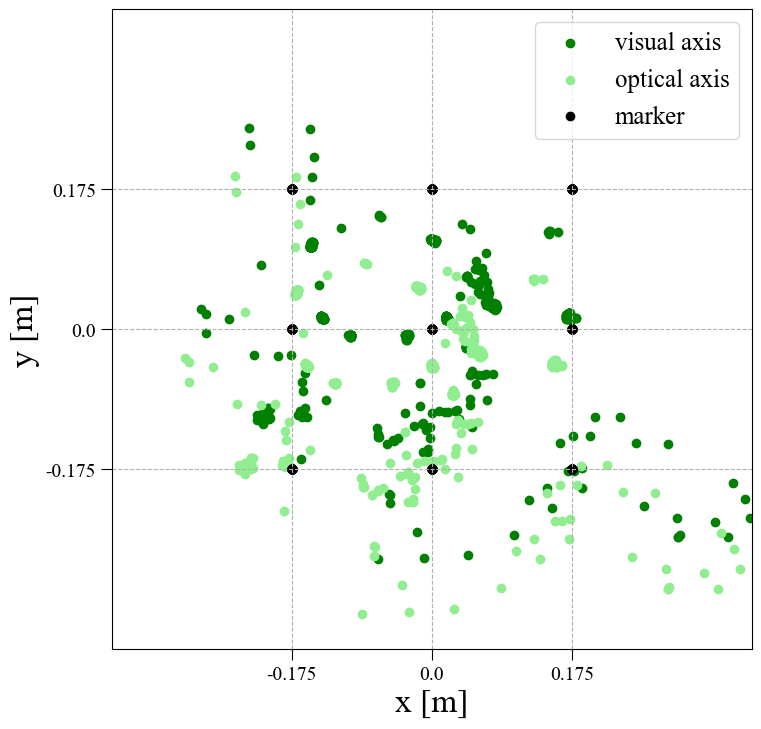

In [15]:
label_xy = [-0.7/4, 0.0, 0.7/4]

# キャリブレーション後
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor("white")

plt.scatter(calib_xh, calib_yh, c="green", label="visual axis")
plt.scatter(calib_xh2, calib_yh2, c="lightgreen", label="optical axis")
plt.scatter(p, q, c="black", label="marker")

plt.xlabel("x [m]",  size=24)
plt.ylabel("y [m]",  size=24)

plt.xlim(-0.4, 0.4)
plt.ylim(-0.4-0.071, 0.4-0.071)
plt.xticks([-0.175, 0.0, 0.175], label_xy, fontsize=14)
plt.yticks([-0.175-0.071, -0.071, 0.175-0.071], label_xy, fontsize=14)

plt.grid(which="major", axis="both", linestyle='--')
plt.tick_params(length=8)
plt.legend(fontsize=18, loc="upper right")
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9)
plt.show()